# Predicting Breast Cancer Diagnosis Using XGBClassifier

This dataset is from the UCI Machine Learning Repository, downloaded from Kaggle. Link [here](https://www.kaggle.com/uciml/breast-cancer-wisconsin-data)

Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image.

Ten real-valued features are computed for each cell nucleus:

a) **radius** (mean of distances from center to points on the perimeter)<br>
b) **texture** (standard deviation of gray-scale values)<br>
c) **perimeter**<br>
d) **area**<br>
e) **smoothness** (local variation in radius lengths)<br>
f) **compactness** (perimeter^2 / area - 1.0)<br>
g) **concavity** (severity of concave portions of the contour)<br>
h) **concave points** (number of concave portions of the contour)<br>
i) **symmetry**<br>
j) **fractal dimension** ("coastline approximation" - 1)<br>

The columns names ending with "se" or "worst" refer to the standard error or the maximum of that feature observed, respectively.

The target column is the binary "diagnosis" column.

# Summary

#### XGBClassifier after 10-fold cross-validation
    * Unscaled
        Test accuracy: 0.9386
        Recall: 0.9
        AUPRC: 0.9699
    * Scaled
        Test accuracy: 0.9386
        Recall: 0.9
        AUPRC: 0.4373
    * Unscaled after dropping low-importance columns:
        Test accuracy: 0.5699
        Recall: 0.3361
        AUPRC: 0.3595
    * Scaled after dropping low_importance columns:
        Test accuracy: 0.5699
        Recall: 0.3361
        AUPRC: 0.3595

In [46]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import warnings
import matplotlib.pyplot as plt
import numpy as np


from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, recall_score, make_scorer, average_precision_score, precision_recall_curve

In [27]:
cancer = pd.read_csv('breast_cancer.csv')

cancer = cancer.drop(['Unnamed: 32', 'id'], axis = 1)

diag_map = {'B':0, 'M': 1}

cancer['diagnosis'] = cancer['diagnosis'].map(diag_map)

In [28]:
X = cancer.drop('diagnosis', 1)
y = cancer['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20, stratify = y)

In [29]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Unscaled

In [30]:
xgb_grid = {
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [50, 100, 150],
    "subsample": [0.7, 0.9],
    "max_depth": [3, 5],
}

model_xgb_grid = GridSearchCV(XGBClassifier(), param_grid = xgb_grid, verbose = 1, n_jobs = -1)
model_xgb_grid.fit(X_train, y_train)

print(model_xgb_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   15.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   21.0s finished


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


In [34]:
model_xgb = XGBClassifier(learning_rate = 0.5, 
                          max_depth = 3, 
                          n_estimators = 100,
                         subsample = 0.9)
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_xgb),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)


print('Training Score: {}'.format(model_xgb.score(X_train, y_train)))
print('Test Score: {}'.format(model_xgb.score(X_test, y_test)))

print(classification_report(y_test, y_pred_xgb))
print(confusion_df)

Training Score: 1.0
Test Score: 0.9824561403508771
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        72
           1       1.00      0.95      0.98        42

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              72               0
Actually Mal.               2              40


In [36]:
cv_scores = cross_val_score(model_xgb, X_test, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_xgb, X_test, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_xgb)))

Mean cross val accuracy: 0.9386363636363635
Mean cross val recall: 0.9
Area under precision-recall curve:0.9699248120300752


In [9]:
importances = model_xgb_grid.best_estimator_.feature_importances_
im_df = pd.DataFrame({"feat": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,feat,importance
22,perimeter_worst,0.377811
27,concave points_worst,0.107975
20,radius_worst,0.088973
23,area_worst,0.074238
7,concave points_mean,0.073565
1,texture_mean,0.028169
6,concavity_mean,0.026674
13,area_se,0.024636
3,area_mean,0.024550
21,texture_worst,0.023002


# Scaled

In [10]:
model_xgb_grid_s = GridSearchCV(XGBClassifier(), param_grid = xgb_grid, verbose = 1, n_jobs = -1)
model_xgb_grid_s.fit(X_train_scaled, y_train)

print(model_xgb_grid_s.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.3s


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    6.0s finished


In [11]:
model_xgb_scale = XGBClassifier(learning_rate = 0.1, 
                          max_depth = 3, 
                          n_estimators = 100, 
                          subsample = 0.9)
model_xgb_scale.fit(X_train_scaled, y_train)
y_pred_xgb_s = model_xgb_scale.predict(X_test_scaled)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_xgb_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_xgb_scale.score(X_train_scaled, y_train)))
print('Test Score: {}'.format(model_xgb_scale.score(X_test_scaled, y_test)))

print(classification_report(y_test, y_pred_xgb_s))
print(confusion_df)

Training Score: 1.0
Test Score: 0.9649122807017544
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        72
           1       0.95      0.95      0.95        42

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              70               2
Actually Mal.               2              40


In [37]:
cv_scores = cross_val_score(model_xgb_scale, X_test_scaled, y_test, cv = 10)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_xgb_scale, X_test_scaled, y_test, cv = 10, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_xgb_s)))

Mean cross val accuracy: 0.9386363636363635
Mean cross val recall: 0.9
Area under precision-recall curve:0.43734335839599


In [14]:
importances = model_xgb_grid_s.best_estimator_.feature_importances_
im_df = pd.DataFrame({"feat": X_train.columns, "importance": importances})
im_df.sort_values("importance", ascending=False)

,feat,importance
22,perimeter_worst,0.377811
27,concave points_worst,0.107975
20,radius_worst,0.088973
23,area_worst,0.074238
7,concave points_mean,0.073565
1,texture_mean,0.028169
6,concavity_mean,0.026674
13,area_se,0.024635
3,area_mean,0.024550
21,texture_worst,0.023002


# Dropping low-importance columns

Threshold = 0.1

## Unscaled

In [15]:
cancer_dropped_u = cancer[['perimeter_worst','concave points_worst', 'diagnosis']]


X = cancer_dropped_u.drop(columns = 'diagnosis')

y = cancer_dropped_u['diagnosis']

X_train_op, X_test_op, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 20)

In [16]:
xgb_grid = {
    "learning_rate": [0.01, 0.1, 0.5],
    "n_estimators": [50, 100, 150],
    "subsample": [0.7, 0.9],
    "max_depth": [3, 5],
}

model_xgb_grid = GridSearchCV(XGBClassifier(), param_grid = xgb_grid, verbose = 1, n_jobs = -1)
model_xgb_grid.fit(X_train_op, y_train)

print(model_xgb_grid.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 128 tasks      | elapsed:    1.3s


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 150, 'subsample': 0.9}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    1.8s finished


In [38]:
model_xgb_op = XGBClassifier(learning_rate = 0.1, 
                          max_depth = 3,
                          n_estimators = 100, 
                          subsample = 0.9)
model_xgb_op.fit(X_train_op, y_train)
y_pred_xgb_op = model_xgb_op.predict(X_test_op)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_xgb_op),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)


print('Training Score: {}'.format(model_xgb_op.score(X_train_op, y_train)))
print('Test Score: {}'.format(model_xgb_op.score(X_test_op, y_test)))

print(classification_report(y_test, y_pred_xgb_op))
print(confusion_df)

Training Score: 0.7824175824175824
Test Score: 0.5701754385964912
              precision    recall  f1-score   support

           0       0.61      0.88      0.72        72
           1       0.18      0.05      0.08        42

    accuracy                           0.57       114
   macro avg       0.40      0.46      0.40       114
weighted avg       0.45      0.57      0.48       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              63               9
Actually Mal.              40               2


In [40]:
cv_scores = cross_val_score(model_xgb_op, X_test_op, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_xgb_op, X_test_op, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_xgb_op)))

Mean cross val accuracy: 0.5699604743083003
Mean cross val recall: 0.33611111111111114
Area under precision-recall curve:0.35953520164046476


## Scaled

In [20]:
scaler = StandardScaler()
scaler.fit(X_train_op)

X_train_scaled_op = scaler.transform(X_train_op)
X_test_scaled_op = scaler.transform(X_test_op)

In [21]:
model_xgb_grid_s = GridSearchCV(XGBClassifier(), param_grid = xgb_grid, verbose = 1, n_jobs = -1)
model_xgb_grid_s.fit(X_train_scaled, y_train)

print(model_xgb_grid_s.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    3.6s


{'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'subsample': 0.7}


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:    8.7s finished


In [41]:
model_xgb_scale_op = XGBClassifier(learning_rate = 0.1, 
                          max_depth = 3,
                          n_estimators = 100, 
                          subsample = 0.9)
model_xgb_scale_op.fit(X_train_scaled_op, y_train)
y_pred_xgb_op_s = model_xgb_scale_op.predict(X_test_scaled_op)

confusion_df = pd.DataFrame(
    confusion_matrix(y_test, y_pred_xgb_op_s),
    index=["Actually Ben.", "Actually Mal.",],
    columns=["Predicted Ben.", "Predicted Mal.",],
)

print('Training Score: {}'.format(model_xgb_scale_op.score(X_train_scaled_op, y_train)))
print('Test Score: {}'.format(model_xgb_scale_op.score(X_test_scaled_op, y_test)))

print(classification_report(y_test, y_pred_xgb_op_s))
print(confusion_df)

Training Score: 0.7824175824175824
Test Score: 0.5701754385964912
              precision    recall  f1-score   support

           0       0.61      0.88      0.72        72
           1       0.18      0.05      0.08        42

    accuracy                           0.57       114
   macro avg       0.40      0.46      0.40       114
weighted avg       0.45      0.57      0.48       114

               Predicted Ben.  Predicted Mal.
Actually Ben.              63               9
Actually Mal.              40               2


In [42]:
cv_scores = cross_val_score(model_xgb_scale_op, X_test_scaled_op, y_test, cv = 5)
print('Mean cross val accuracy: {}'.format(cv_scores.mean()))

cv_scores = cross_val_score(model_xgb_scale_op, X_test_scaled_op, y_test, cv = 5, scoring = make_scorer(recall_score))
print('Mean cross val recall: {}'.format(cv_scores.mean()))

print('Area under precision-recall curve:{}'.format(average_precision_score(y_test, y_pred_xgb_op_s)))

Mean cross val accuracy: 0.5699604743083003
Mean cross val recall: 0.33611111111111114
Area under precision-recall curve:0.35953520164046476


# Visualizations

## Unscaled

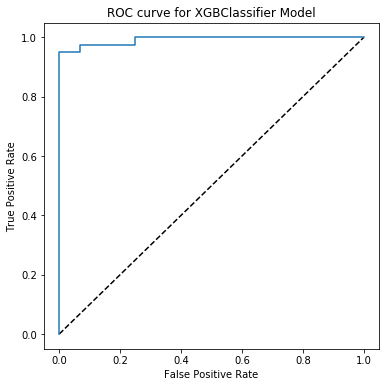

In [44]:
probs = model_xgb.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for XGBClassifier Model')
plt.show()

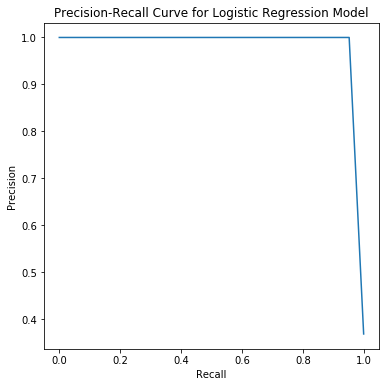

In [47]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_xgb)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

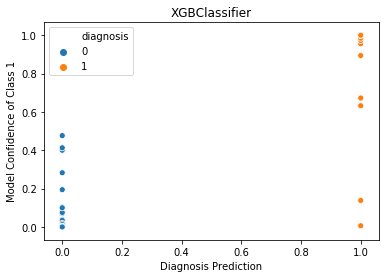

In [48]:
confidence = model_xgb.predict_proba(X_test)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('XGBClassifier')
plt.show()

## Scaled

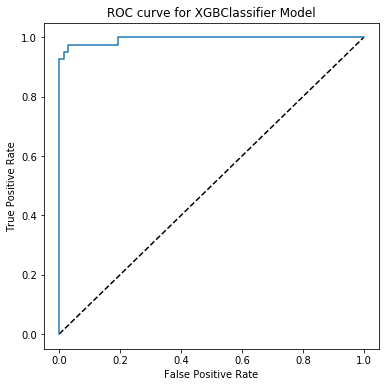

In [49]:
probs = model_xgb_scale.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for XGBClassifier Model')
plt.show()

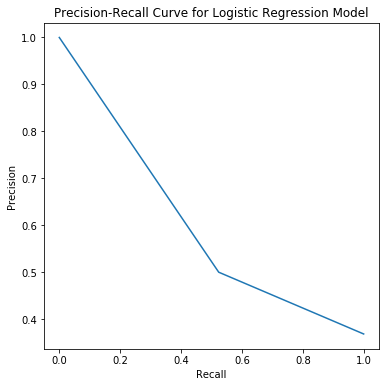

In [50]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_xgb_s)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

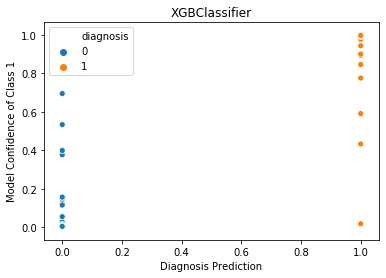

In [51]:
confidence = model_xgb_scale.predict_proba(X_test_scaled)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('XGBClassifier')
plt.show()

## Unscaled optimized

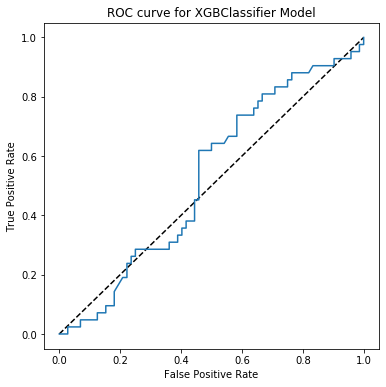

In [52]:
probs = model_xgb_op.predict_proba(X_test_op)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for XGBClassifier Model')
plt.show()

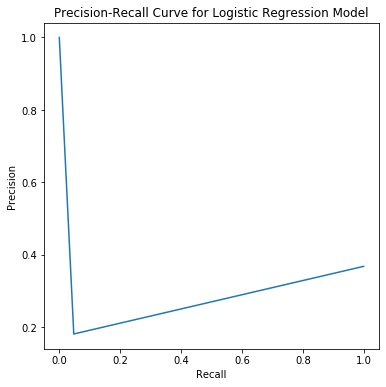

In [53]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_xgb_op)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

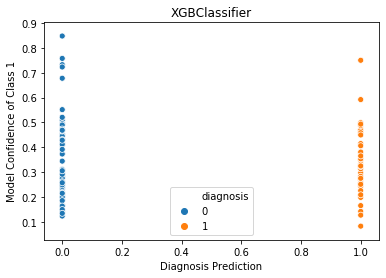

In [54]:
confidence = model_xgb_scale_op.predict_proba(X_test_scaled_op)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('XGBClassifier')
plt.show()

## Scaled optimized

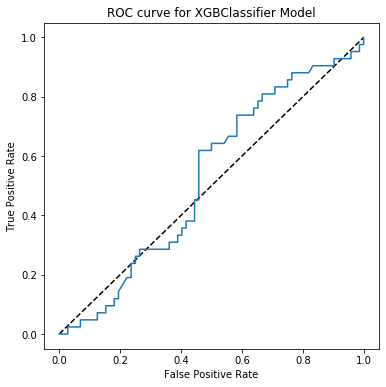

In [55]:
probs = model_xgb_scale_op.predict_proba(X_test_scaled_op)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

fig = plt.figure(figsize = (6, 6))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for XGBClassifier Model')
plt.show()

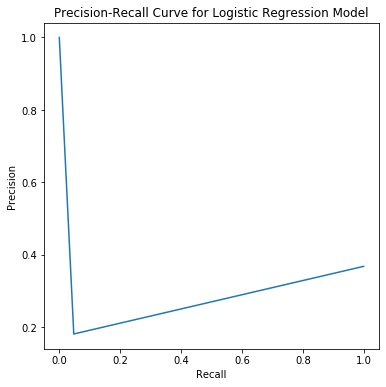

In [56]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_xgb_op_s)

fig = plt.figure(figsize = (6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression Model')
plt.show()

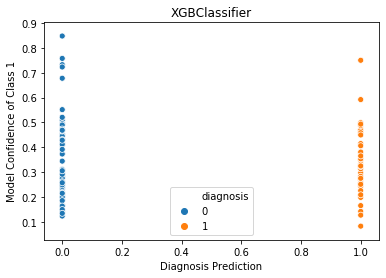

In [58]:
confidence = model_xgb_scale_op.predict_proba(X_test_scaled_op)[:,1]

sns.scatterplot(y_test, confidence, hue = y_test)
plt.ylabel('Model Confidence of Class 1')
plt.xlabel('Diagnosis Prediction')
plt.title('XGBClassifier')
plt.show()